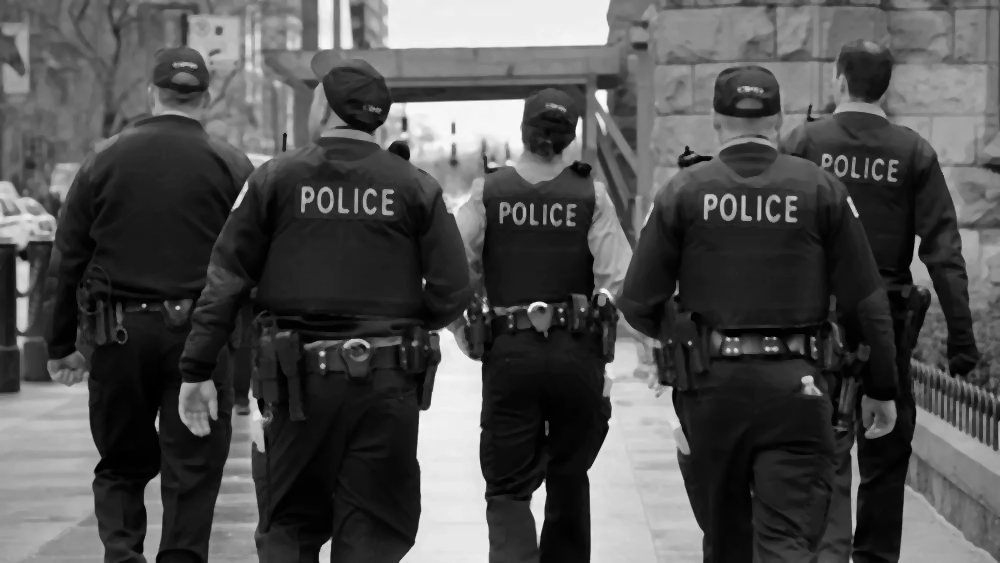

## 1. Introduction

### 1.1 Aim

This project explores the 'Fatal Police Shootings in the US' dataset. Firstly, we will assess whether race has a significant association with police killings across armed and unarmed individuals. Following this, we will use supervised feature ranking to assess feature importance for the deaths of unarmed individuals at the hands of police.

### 1.2 Data

*'The 2014 killing of Michael Brown in Ferguson, Missouri, began the protest movement culminating in Black Lives Matter and an increased focus on police accountability nationwide.Since Jan. 1, 2015, The Washington Post has been compiling a database of every fatal shooting in the US by a police officer in the line of duty.It's difficult to find reliable data from before this period, as police killings haven't been comprehensively documented, and the statistics on police brutality are much less available. As a result, a vast number of cases go unreported.*

*The Washington Post is tracking more than a dozen details about each killing - including the race, age and gender of the deceased, whether the person was armed, and whether the victim was experiencing a mental-health crisis. They have gathered this information from law enforcement websites, local new reports, social media, and by monitoring independent databases such as "Killed by police" and "Fatal Encounters". The Post has also conducted additional reporting in many cases.*

*There are four additional datasets. These are US census data on poverty rate, high school graduation rate, median household income, and racial demographics.*

*Source of census data:
https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml '*

## 2. Data preparation

### 2.1 Data evaluation

Let's load the dataset into pandas:

In [36]:
#import modules
import pandas as pd

#load data
df = pd.read_csv("D:\DSProjects\Data_Science\Quick Projects\police_killings\PoliceKillingsUS.csv", encoding="windows-1252")

#view df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2535 non-null   int64  
 1   name                     2535 non-null   object 
 2   date                     2535 non-null   object 
 3   manner_of_death          2535 non-null   object 
 4   armed                    2526 non-null   object 
 5   age                      2458 non-null   float64
 6   gender                   2535 non-null   object 
 7   race                     2340 non-null   object 
 8   city                     2535 non-null   object 
 9   state                    2535 non-null   object 
 10  signs_of_mental_illness  2535 non-null   bool   
 11  threat_level             2535 non-null   object 
 12  flee                     2470 non-null   object 
 13  body_camera              2535 non-null   bool   
dtypes: bool(2), float64(1), 

We can see our data is comprised of 14 variables and 2535 data points. The dataset contains a mixture of data types: discrete integer, float, bool, and object.

### 2.2 Data cleansing

We don't need unique identifiers, dates, or regional information so let's drop the variables `id`, `name`, `date`, `city`, and `state` from our data frame:

In [37]:
#drop undesired variables
df.drop(columns = ['id', 'name', 'date', 'city', 'state'], inplace = True)

#show columns in transforemd df
print("columns in transformed dateframe:", df.columns.tolist())

columns in transformed dateframe: ['manner_of_death', 'armed', 'age', 'gender', 'race', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera']


Now let's assess data completeness:

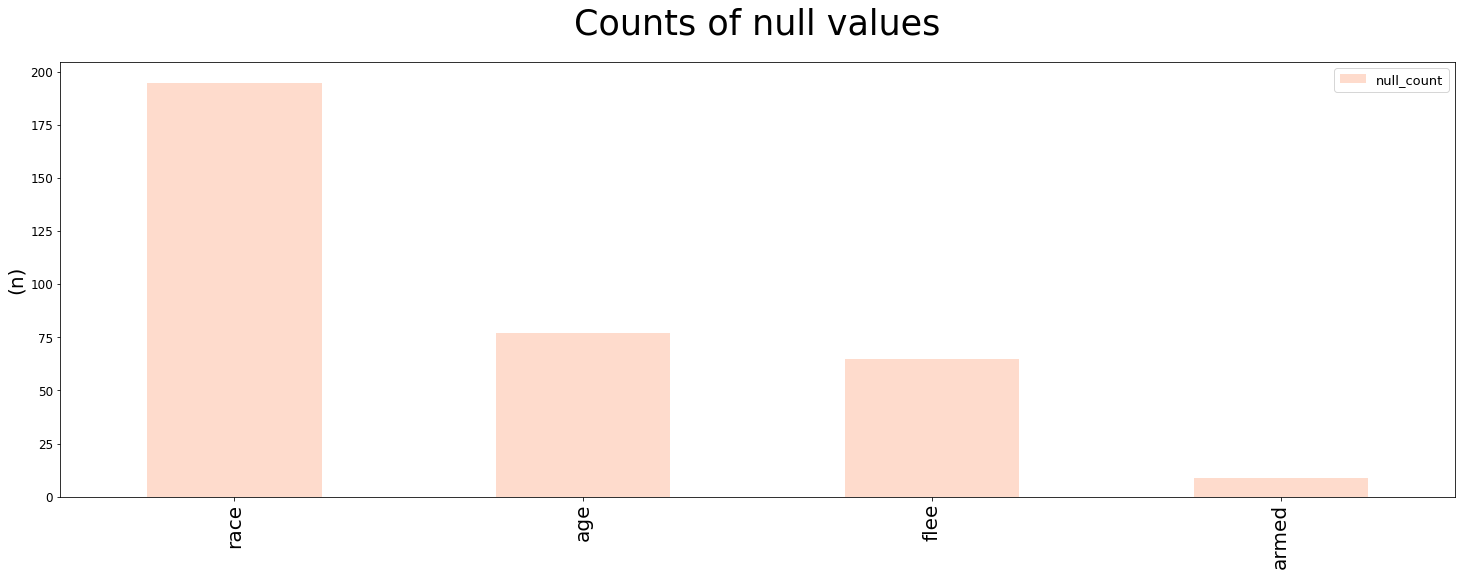

In [38]:
#import modules
import seaborn as sns
import matplotlib.pyplot as plt

#set seaborn style
sns.set_palette('Reds')

#create dict of columns with null counts
null_values = {}
for col in df.columns:
    try:
        null_values.update({col : df[col].isnull().value_counts()[1]})
    except:
        pass

#create dataframe of null counts
polkill_null_df = pd.DataFrame.from_dict(null_values, orient = 'index', columns = ['null_count']).sort_values(by="null_count", ascending = False)

#create plot
ax = polkill_null_df.plot.bar(figsize=(25,8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.ylabel("(n)", fontsize = 20)
plt.title('Counts of null values', fontsize = 35, y = 1.05, x = 0.5)
plt.legend(fontsize = 13)

#show plot
plt.show()

The graph shows four variables have missing data: `race`, `age`, `flee` and `armed`. `race` is missing the most data, with 195 null rows, making up ~8% of the total row count. 

**Data removal**

Two common methods of handling null data are imupataion and removal. Mean imputation replaces null values with the mean for a given variable. This can shrink standard errors, misrepresent relationships between variables, and ultimately impair result generalizability. We will be investigating the variables `race` and `armed` in our significance testing, so we want them both to be as accurate as possible. We will drop any rows containing null values in `race` and `armed` to keep data on these key variables as accurate as possible in an attempt to retain generalizability for our dataset: 

In [39]:
#drop race na rows
polkill_drop_df = df[df.race.notna()]
polkill_df = polkill_drop_df[polkill_drop_df.armed.notna()]
polkill_df = polkill_df.reset_index(drop = True)

#print new df shape
print("number of rows dropped:", df.shape[0] - polkill_df.shape[0], "\ndataframe size: ", polkill_df.shape)

number of rows dropped: 201 
dataframe size:  (2334, 9)


Using the approximation that any given sample should have a ratio of ~10:1 for data points to variables, the sample size of 2334 is above the recommended baseline value of 140 (14 * 10). Therefore, dropping null values shouldn't be too detrimental to generalizability of our analyses.

**Data imputation**

`age` and `flee` contain a small proportion (<5%) of null values. As neither are essential for significance testing, we will impute null values. It's more beneficial to retain data across other key variables (such as `armed` and `race`) than deleting the datapoint altogether. Let's impute the outstanding null variables `age` & `flee`:

In [40]:
#fill null values with column mode
for col in polkill_df:
    polkill_df[col].fillna(polkill_df[col].mode()[0], inplace=True)

#show null value counts
print(f"null values present:\n{polkill_df.isna().sum()}")

null values present:
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
dtype: int64


We can see that the transformed data frame contains no null values after data removal and imputation.

### 2.3 Data exploration & grouping

Grouping variable values can focus data on important sub-populations and improve the accuracy of estimation for statistical algorithms. Let's check the number of unique values across variables and assess whether statistical tests would benefit from grouping variables:

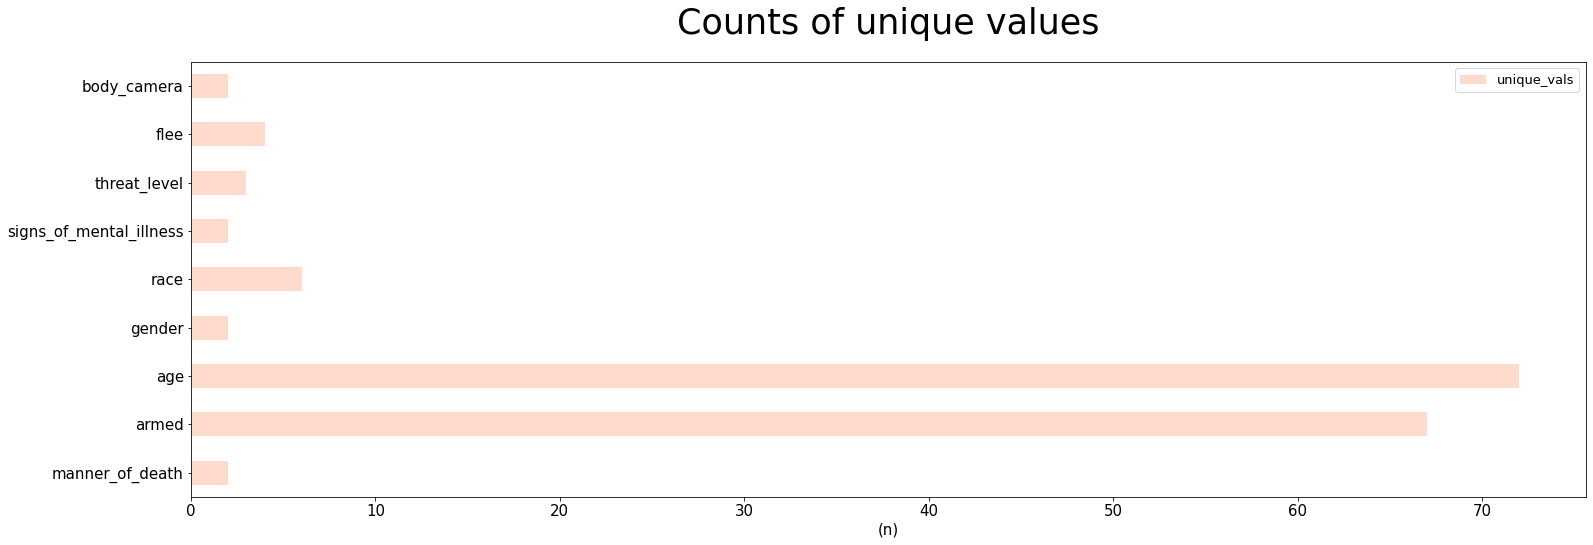

In [41]:
#create dict
counts_dict = {}

#loop through to create dict of unqiue values
for col in polkill_df.columns:
    counts_dict.update({col:[len(polkill_df[col].unique())]})
    
#show in bar chart
pd.DataFrame.from_dict(counts_dict, orient = 'index', columns = ['unique_vals']).plot.barh(figsize = (25,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("(n)", fontsize = 15)
plt.title('Counts of unique values', fontsize = 35, y = 1.05, x = 0.5)
plt.legend(fontsize = 13)
plt.show()

The horizontal bar chart above shows the number of unique values across each variable in our data frame. The large majority of variables have less than 10 unique values, with the exceptions of `armed` and `age` which have 67 and 72 unique values respectively. The variable `armed` isn't independent of our outcome variable, so will be discounted. We will look at the distribution of unique values across `age` to determine whether binning/grouping is appropriate.

**Age**

Let's assess the distribution of `age`:

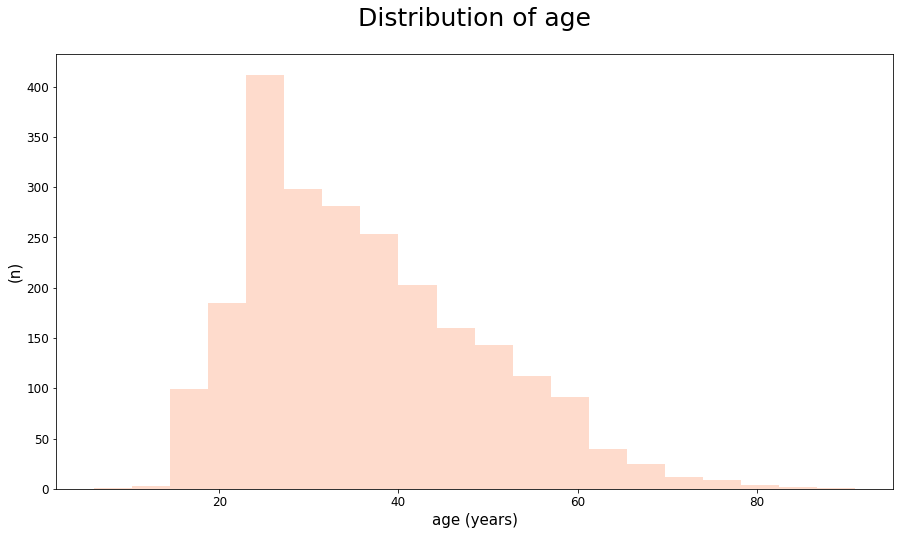

In [42]:
#create plot
ax = polkill_df.age.plot.hist(bins = 20, figsize = (15,8))

#add labels
plt.title("Distribution of age", fontsize = 25, y = 1.05, x = 0.5)
plt.xlabel("age (years)", fontsize =15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("(n)", fontsize = 15)


#show plot
plt.show()

The histogram above shows that age follows a right-skewed distribution with the majority of ages falling between 16 - 65. Values peak at around ~26 years. We will group `age` in intervals of 10 from ages 16-65 with generic groups for above (65<) and below (<16):

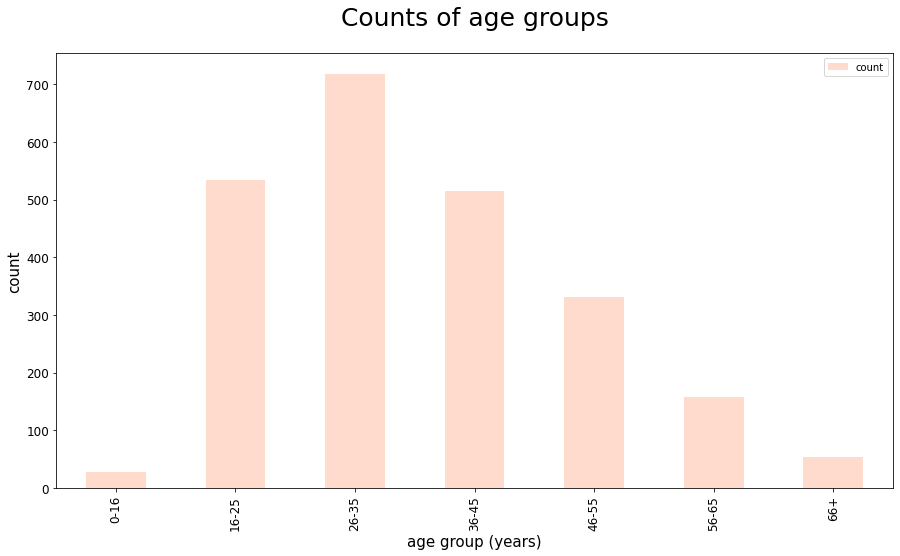

In [43]:
#create variables of terms
age_group = []
age_index = []

#loop through groupings
for num, val in enumerate(polkill_df.age): #to keep indexes when merging dfs
      
    if val <= 16:
        age_group.append("0-16")
        age_index.append(num)
    elif val < 26:
        age_group.append("16-25")
        age_index.append(num)
    elif val < 36:
        age_group.append("26-35")
        age_index.append(num)
    elif val < 46:
        age_group.append("36-45")
        age_index.append(num)
    elif val < 56:
        age_group.append("46-55")
        age_index.append(num)
    elif val < 66:
        age_group.append("56-65")
        age_index.append(num)
    elif val >= 66:
        age_group.append("66+")
        age_index.append(num)

#create and merge dataframes
age_group = pd.DataFrame(age_group, age_index, ['age_group'])
polkill_df = pd.concat([polkill_df, age_group], axis=1)

#create dataframe for bar chart
ind_order = [3,2,4,5,6,7,1] #to order age groups in ascending order

#create dataframe
age_g_counts = polkill_df.age_group.value_counts()
group_age_df = pd.DataFrame([age_g_counts.index, age_g_counts.values]).T
group_age_df.index = ind_order
group_age_df.sort_index(inplace = True)
group_age_df.columns = ['age_group', 'count']

#create chart
ax = group_age_df.plot.bar(figsize = (15,8))

#change x-tick labels
ax.set_xticklabels(group_age_df.age_group.values)

#add labels
plt.title("Counts of age groups", fontsize = 25, y = 1.05, x = 0.5)
plt.xlabel("age group (years)", fontsize =15)
plt.ylabel("count", fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#show plot
plt.show()

The bar chart above shows the counts for each unique value in `age_group`. The similar distribution profiles of the above bar chart and `age` histogram show that the grouped variable `age_group` has retained the distribution its originator variable `age`.

## 3. Racial representation in the killings of armed and unarmed individuals

### 3.1 Data visualization

One aim this project is to assess whether racial groups are overrepresented in police killings of unarmed individuals versus the armed equivalents. First, we will compare the racial representation between armed and unarmed killings. Relative representation will be calculated using y = x(armed) - x(unarmed), where x = proportion for a given race. Racial abbreviations are as follows: W = White, B = Black, H = Hispanic, O = Other, N = Native American, A = Asian.

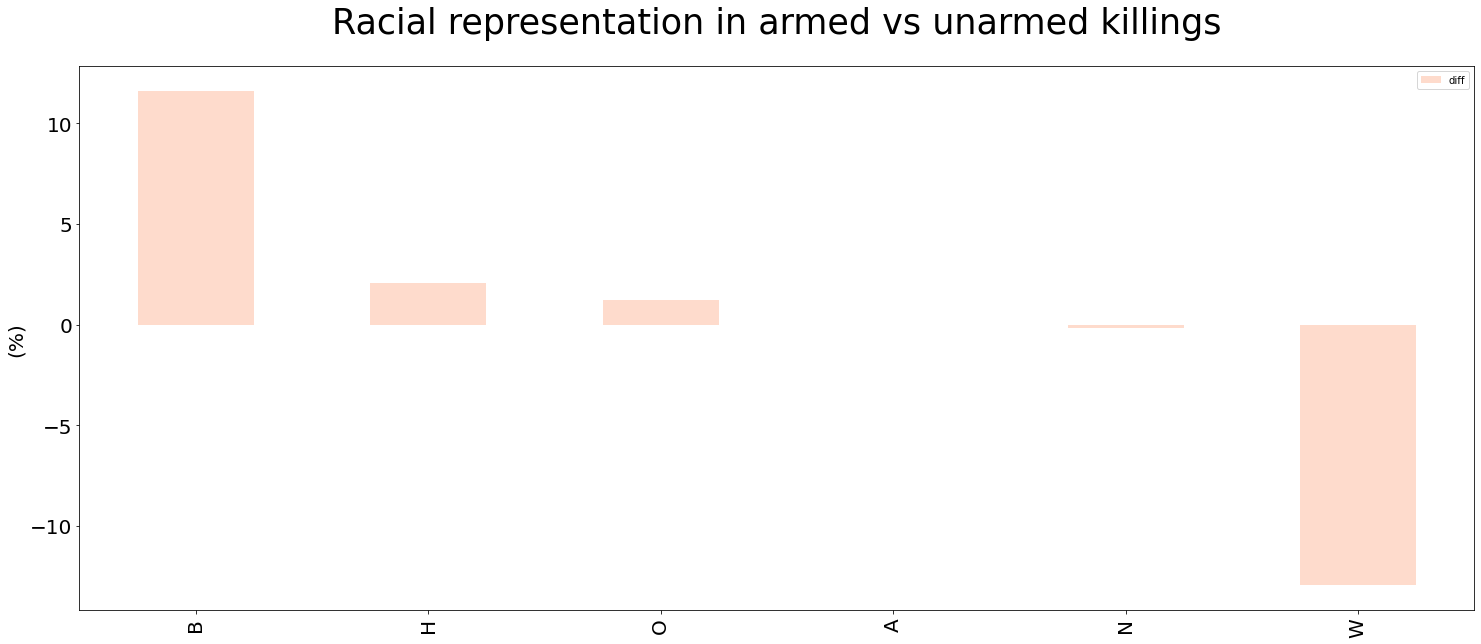

In [44]:
#calculate the difference in proportions of unarmed and armed kills per race
unarmed_prop = polkill_df.query('armed == "unarmed"').race.value_counts()/polkill_df.query('armed == "unarmed"').race.value_counts().sum()
armed_prop = polkill_df.query('armed != "unarmed"').race.value_counts()/polkill_df.query('armed != "unarmed"').race.value_counts().sum()
diff_prop = (unarmed_prop - armed_prop)


#turn into percentage in DataFrame
diff_df = pd.DataFrame(diff_prop)*100
diff_df.columns = ['diff']
diff_df.fillna(0, inplace=True)
diff_df.sort_values(by ='diff', ascending = False, inplace = True)

#plot graph
ax = diff_df.plot.bar(figsize = (25,10), fontsize = 20)
plt.title("Racial representation in armed vs unarmed killings", fontsize = 35, y = 1.05, x = 0.5)
plt.ylabel("(%)", fontsize = 20)
plt.show()

The bar chart above shows the differences between the proportions of racial groups observed in unarmed and armed killings, where a positive value indicates a given race overrepresented in unarmed killings and vice versa. We can see that `black` people are the most overrepresented in unarmed killings by ~14%, followed by `hispanic` and `other`, with 4% and 2% respectively. Inversely, `white` people are underrepresented by ~16% in unarmed killings. Differences in the representation of `asian` and `native armericans` are negligible across both groups.

### 3.2 Significance testing: Pearson’s chi-square contingency

The Pearson’s chi-squared contingency hypothesis is a test for independence between the observed and expected frequencies when comparing two or more categorical variables. We will conduct a chi-square contingency test, where our null hypothesis states that there is no significant difference between the proportions of races seen in armed and unarmed individuals killed by police. We will use a significance threshold of p < 0.05.

In [45]:
#import modules
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

#create categorical target variable for armed and unarmed deaths
unarmed = []
for val in polkill_df.armed:
    if val == 'unarmed':
        unarmed.append(1)
    else:
        unarmed.append(0)

#add to df
polkill_df['unarmed'] =  unarmed

#assign variable for encoder
enc = LabelEncoder()

#calculate chi2 contingency sta
chi2_val, p_val = list(chi2_contingency(pd.crosstab(pd.Series(enc.fit_transform(polkill_df['race'])), polkill_df['unarmed']))[0:2])

#print p-value
print("p-value: ", p_val)

p-value:  0.002188638287561445


We can see that the chi2 contingency p-value sits well under the 0.05 threshold, rejecting the null hypothesis.

## 3. Feature Engineering

Before we begin feature ranking, we will attempt to improve classification performance. Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms.

**Dropping variables**

Before beginning feature engineering, we need to drop any redundant variables. We will remove `armed` as it isn't independent of the outcome variable.  We will also drop `age` as we've created a replacement grouped variable (`age_group`), and `manner_of_death` because were only interested in the death as an outcome, not the tools used to kill an individual. Let's drop the undesired variables:

In [46]:
#create x and y variables
y = polkill_df.unarmed
X = polkill_df.drop(columns = ['unarmed', 'age', 'manner_of_death', 'armed'])

#assess new df
X.columns

Index(['gender', 'race', 'signs_of_mental_illness', 'threat_level', 'flee',
       'body_camera', 'age_group'],
      dtype='object')

**Encoding dummy variables**

Machine learning algorithms tend to perform better when categorical variables are split out into binarized columns. Pandas comes with a function pd.dummy which binarizes categorical variables. Let's split our categorical variables into dummy variables:

In [47]:
#encode dummy variables
X = pd.get_dummies(X)

#show transformed df shape
X.head()

,signs_of_mental_illness,body_camera,gender_F,gender_M,race_A,race_B,race_H,race_N,race_O,race_W,...,flee_Foot,flee_Not fleeing,flee_Other,age_group_0-16,age_group_16-25,age_group_26-35,age_group_36-45,age_group_46-55,age_group_56-65,age_group_66+
0,True,False,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,False,False,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,False,False,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,True,False,0,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
4,False,False,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0


We can see the number of columns has increased from 11 to 24 following variable encoding. Now let's use sklearn LabelEncoder to transform categorical variables into binary variables:

In [48]:
#assign encoder
enc = LabelEncoder()

#transform variables
X['signs_of_mental_illness'] = enc.fit_transform(X['signs_of_mental_illness'])
X['body_camera'] = enc.fit_transform(X['body_camera'])

#show example of encoded variable
X.body_camera.value_counts()

0    2078
1     256
Name: body_camera, dtype: int64

## 4. Feature ranking

Feature ranking is the process of ordering the features in order of feature importance. We will use L1 regularisation classification to rank features by their predictive importance to a target variable, in this case, their ability to predict whether an individual killed by the police was unarmed.

**L1 regularization classification**

L1-regularization adds L1 penalty variables, which forces many varaibles to a coefficeint of zero as regularization strength increases. Thus weak features should have zero as coefficients. It also creates coefficient scores features with both positive and negative values.

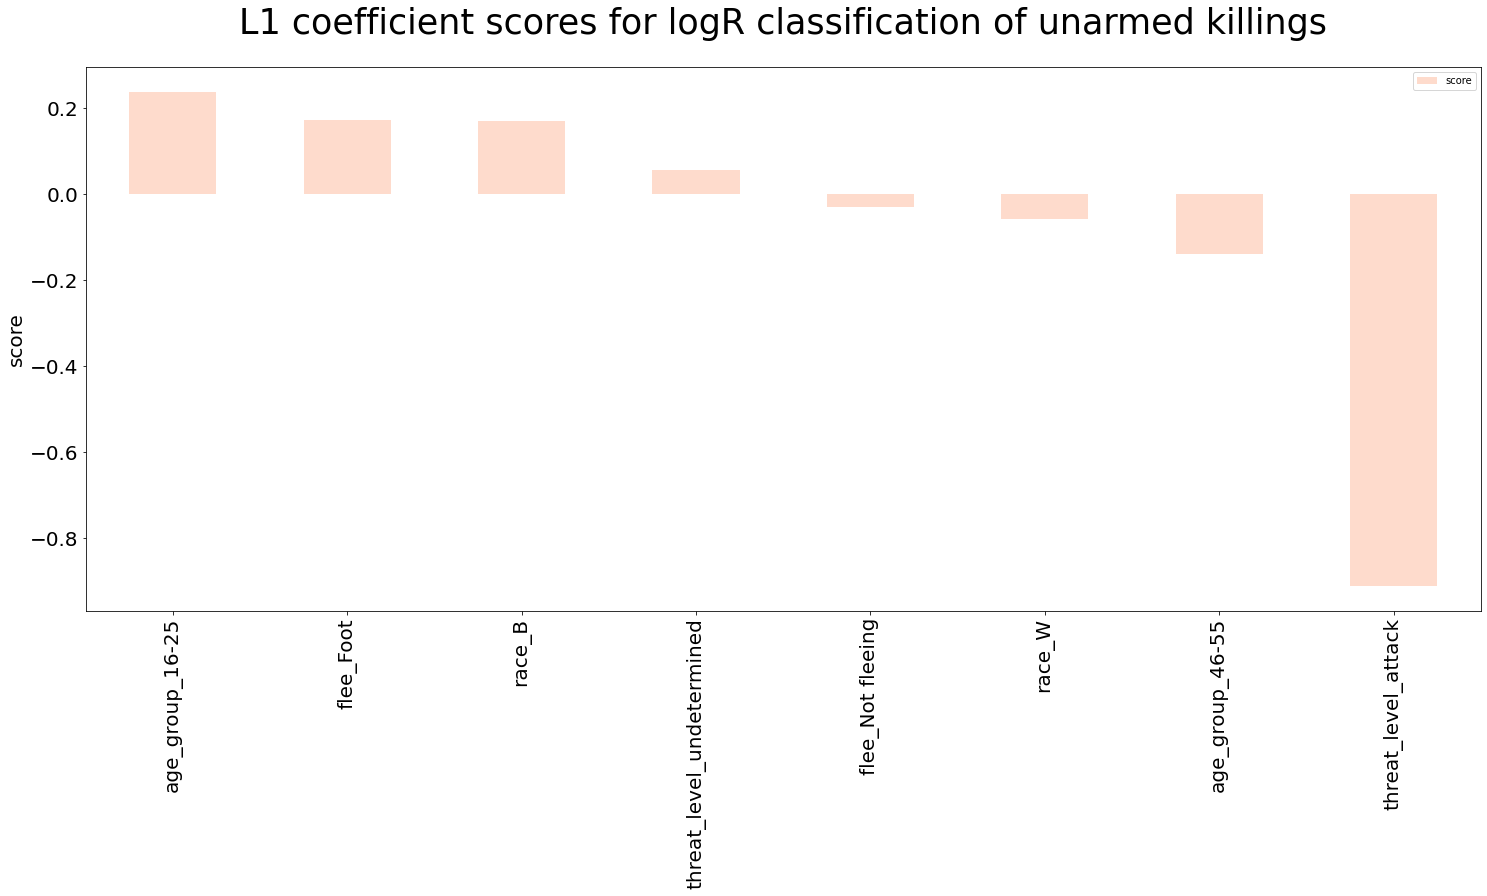

In [49]:
from sklearn.linear_model import LogisticRegression

#assing and fit regression model
clf = LogisticRegression(penalty = 'l1', C = 0.1, solver='saga')
clf.fit(X,y)

#loop through scores
scores = []
for i in range(len(X.columns)):
    coef = clf.coef_[0,i]
    scores.append(coef)

#create df of scores        
diff_df  = pd.DataFrame(scores, X.columns, columns = ['score']).sort_values(by = 'score', ascending = False).query('score != 0')

ax = diff_df.plot.bar(figsize = (25,10), fontsize = 20)
plt.title("L1 coefficient scores for logR classification of unarmed killings", fontsize = 35, y = 1.05, x = 0.5)
plt.ylabel("score", fontsize = 20)
plt.show()

The bar chart above shows the L1 coefficient scores produced from our logistic regression modeling of unarmed police killings. The variables `age_group_16-25`, `flee_Foot`, and `race_B` all have positive coefficient values and help predict unarmed killings. Inversely, `threat_level_attack`, `race_W`, `age_group_46-55`, `flee_Not fleeing` all have negative scores and are predictors armed killings. The value `'threat_level_attack'` is the strongest predictor amongst our selected variables with a coefficient score of -0.86, over x2.5 larger than the second strongest predictor `age_group_16-25`. All other variables had coefficient scores within a 0.3 range from 0.

## 5. Discussion

Characteristics of the 'PoliceKillingsUS' dataset supported the inferential techniques implemented in the study. The large dataset was found to be mostly complete, with a relatively small amount of imputation and deletion required. Large sample size and high completeness reduced the likelihood of overfitting to certain data points and increased inferential generalizability from our analyses. The only contentious characteristic of the dataset was the fairly small number of unarmed police killing records. Even though the 'unarmed' subset exceeded the recommended base sample size, additional supporting data would improve robustness and validate interpretation.

The chi2 contingency test showed a significant association between racial representations in the police killings of unarmed versus armed individuals, with a p-value well below the significance threshold. Further analysis comparing the difference in the proportions of armed and unarmed killings for each race highlighted racial disproportionality amongst unarmed individuals, showing that unarmed black individuals are subject to ~29% more police killings than white individuals, proportionate to their race. This highlights a potential racial bias in the killing of unarmed black Americans, although further domain-specific research would be required to determine any contextual significance to these findings.

Supervised feature ranking identified 'threat_level_attack' as the strongest predictor for an armed killing with a coefficient score above 0.8. This is likely because individuals are much more likely to attack police when armed, as oppose to unarmed. There appear to be dichotomous relationships between positive and negative predictors of armed police killings. For example, `age_group_16-25` had a positive coefficient, whereas `age_group_46-55` had a negative coefficient as predictors. This can see bee seen across the variables `race`, `flee` too. This dichotomy across variables could highlight a potential age and race bias across armed and unarmed individuals killed by police. Again, further domain-specific research is necessary to establish contextual significance for these findings. 

The results and provenance of the data create two lines of inquiry for follow-up studies. Both the significance testing and feature ranking exercises highlight the potential for racial discrimination in police killings. Contextual evaluation of the results could aid interpretation of the findings of this study. Secondly, all data for this study came from one source (The Washington Post). Corroborations of findings using the same methodology on different datasets would enhance the validity of the study.

Overall, the project succeeded in establishing significant associations between racial representations in the police killings of unarmed versus armed individuals. Furthermore, we successfully ranked feature importance in unarmed police killings using a supervised L1 regularization classification model. Further contextual investigation into results would help better understand potential discrimination in `race` and `age` of unarmed individuals killed by police in the US.